In [1]:
# Import libraries
import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearn.cluster import DBSCAN
import numpy as np
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
from scipy.stats import linregress

In [2]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,
                                                            npy_dir+'X/',
                                                            npy_dir+'R/',
                                                            npy_dir+'K/',
                                                            n_rois,1595,all_rois)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)

X_all_c, K, R, subsc, pre_imp, pre_updrs_off, per_change = util.re_index(X_all,
                                                                         K_all,
                                                                         R_all,
                                                                         c_cases_idx,
                                                                         subs,
                                                                         ids,
                                                                         all_rois,
                                                                         pre_imp,
                                                                         pre_updrs_off,
                                                                         post_imp)

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
['Left red nucleus' 'Left substantia nigra' 'Left subthalamic nucleus'
 'Right Substantia nigra' 'Right red nucleus' 'Right subthalamic nucleus']


In [19]:
# Training parameters
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
y_err = np.zeros_like(per_change)
nd = np.zeros_like(per_change)
pd = np.zeros_like(per_change)
dn = np.zeros_like(per_change)
all_rois = False
scale_together = False
# Train
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # Cross validation
    cvn = 5
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,True,False)
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k=1700)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      d_n,y_n = cKDTree(X0_ss0).query(X_test_ss0, k=1)

      
    # LASSO
    lasso = slm.LassoCV(max_iter=int(1e4),cv=cvn,eps=1e-3)
    est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss).item()
    y_err[j] = np.abs((per_change[j]-results_ls[j]))
    nd[j] = np.abs(per_change[j]-y_train[y_n])
    pd[j] = np.abs(results_ls[j]-y_train[y_n])
    dn[j] = d_n
    # Training status
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          #'and',str(np.round(results_bls[j],2)),
          # 'with regularization',str(np.round(est_bls.alpha_,5)),
           'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))



Lasso predicts 0.44 for case 67 with 0.48
Lasso predicts 0.53 for case 75 with 0.97
Lasso predicts 0.57 for case 68 with 0.75
Lasso predicts 0.66 for case 79 with 0.66
Lasso predicts 0.91 for case 59 with 0.74
Lasso predicts 0.48 for case 85 with 0.15
Lasso predicts 0.86 for case 63 with 0.85
Lasso predicts 0.36 for case 66 with 0.53
Lasso predicts 0.65 for case 86 with 0.5
Lasso predicts 0.55 for case 69 with 0.49
Lasso predicts 0.49 for case 72 with 0.26
Lasso predicts 0.7 for case 80 with 0.52
Lasso predicts 0.65 for case 81 with 0.19
Lasso predicts 0.73 for case 77 with 0.56
Lasso predicts 0.9 for case 64 with 0.66
Lasso predicts 0.62 for case 83 with 0.84
Lasso predicts 0.5 for case 62 with 0.47
Lasso predicts 0.55 for case 87 with 0.09
Lasso predicts 0.77 for case 58 with 0.52
Lasso predicts 0.55 for case 89 with 0.36
Lasso predicts 0.59 for case 78 with 0.82
Lasso predicts 0.52 for case 90 with 0.3
Lasso predicts 0.65 for case 61 with 0.85
Lasso predicts 0.69 for case 1 with 0.8

Text(0.5, 1.0, 'Feature space distance and prediction error')

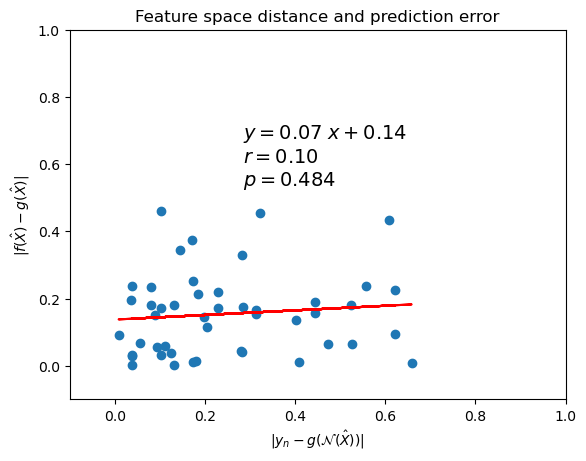

In [20]:
fig,ax = plt.subplots()
plt.scatter(nd,y_err)
lr_prepost = linregress(nd,y_err)
plt.plot(nd,nd*lr_prepost.slope+lr_prepost.intercept,'-r')
text = f"$y={lr_prepost.slope:0.2f}\; x{lr_prepost.intercept:+0.2f}$\n$r = {lr_prepost.rvalue:0.2f}$\n$p = {lr_prepost.pvalue:0.3f}$"
plt.text(0.35, 0.75, text,transform=ax.transAxes,
            fontsize=14, verticalalignment='top')
plt.xlabel(r'$|y_n-g(\mathcal{N}(\hat{X}))|$')
plt.ylabel(r'$|f(\hat{X})-g(\hat{X})|$')
plt.xlim(-0.1,1)
plt.ylim(-0.1,1)
plt.title('Feature space distance and prediction error')

In [21]:
y_ns = cKDTree(X0_ss).query(X0_ss,k=2)

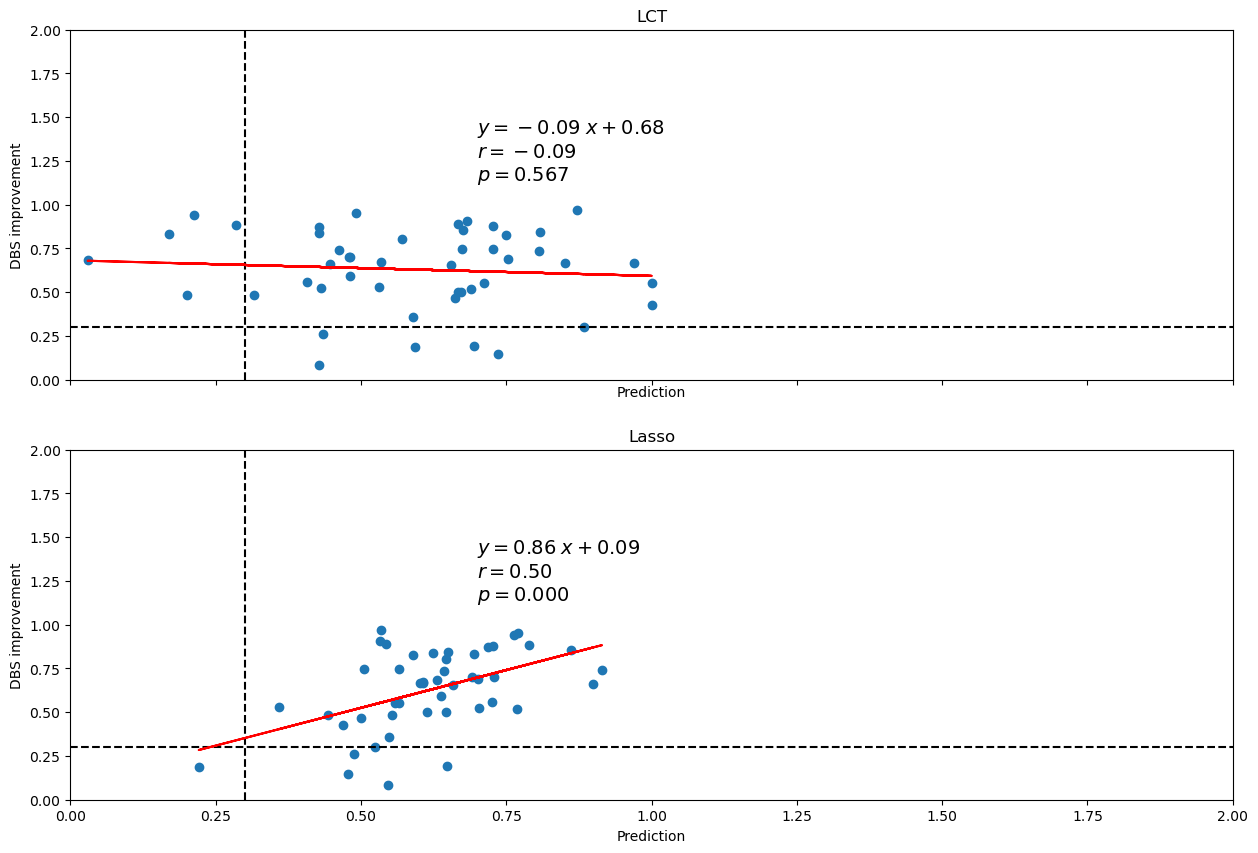

In [22]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               #results_bls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                               # 'MLP'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

